# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import seaborn as sns
import datetime
from pyspark import SparkFiles
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, RandomForestClassifier, RandomForestClassificationModel, GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '46571'),
 ('spark.app.id', 'local-1566874716039'),
 ('spark.driver.host', 'e2d178e02c72'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
df.count()

286500

In [7]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [8]:
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [18]:
format_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", format_time(df.ts))
df = df.withColumn("regdate", format_time(df.registration))
df.createOrReplaceTempView("df")

In [33]:
spark.sql('''SELECT DISTINCT page
          FROM df           
          LIMIT 1000''').show(1000)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [54]:
spark.sql('''SELECT DISTINCT userID
          FROM df 
          WHERE page == "Cancellation Confirmation"
          Group by userID,page
          LIMIT 1000''').count()

52

In [53]:
spark.sql('''SELECT userID, song, page, sessionID, time 
          FROM df 
          WHERE userID == '10'
          ORDER BY time 
          LIMIT 1000''').count()

795

In [36]:
churn_users = spark.sql('''SELECT DISTINCT userID
          FROM df 
          WHERE page == "Cancellation Confirmation"
          Group by userID
          LIMIT 1000''').collect()
churn_users_list = [(row['userID']) for row in churn_users]
df_churn_users = df.withColumn("churn", df.userId.isin(churn_users_list))

In [37]:
df_churn_users.createOrReplaceTempView("df_churn")
spark.sql('''SELECT COUNT(DISTINCT userID), MONTH(time) as month, YEAR(time) as year
          FROM df_churn 
          GROUP BY month, year
          ORDER BY year, month
          LIMIT 1000''').show()

+----------------------+-----+----+
|count(DISTINCT userID)|month|year|
+----------------------+-----+----+
|                   213|   10|2018|
|                   187|   11|2018|
|                     4|   12|2018|
+----------------------+-----+----+



In [38]:
spark.sql('''SELECT COUNT(DISTINCT userID),MONTH(regdate) as regmonth, YEAR(regdate) as regyear
          FROM df_churn 
          GROUP BY regmonth,regyear
          ORDER BY regyear,regmonth
          LIMIT 1000''').show()

+----------------------+--------+-------+
|count(DISTINCT userID)|regmonth|regyear|
+----------------------+--------+-------+
|                     1|       3|   2018|
|                     2|       5|   2018|
|                    10|       6|   2018|
|                    28|       7|   2018|
|                    50|       8|   2018|
|                   129|       9|   2018|
|                     1|      10|   2018|
|                     4|      11|   2018|
+----------------------+--------+-------+



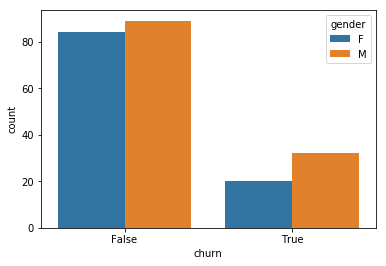

In [39]:
df_churn_users.createOrReplaceTempView("df_churn")
plot_gender = spark.sql('''SELECT COUNT(DISTINCT userID) as count, gender, churn
          FROM df_churn 
          Group by gender, churn
          ORDER BY churn
          LIMIT 1000''').toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=plot_gender);

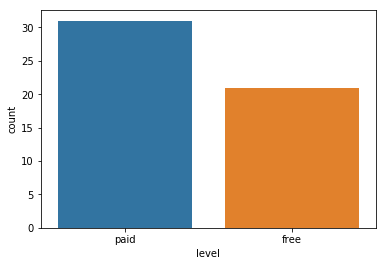

In [40]:
plot_level = spark.sql('''SELECT COUNT(DISTINCT userID) as count, level, churn
          FROM df_churn 
          Where page == "Cancellation Confirmation"
          Group by level, churn
          ORDER BY churn
          LIMIT 1000''').toPandas()
sns.barplot(x='level', y='count', data=plot_level);

In [41]:
spark.sql('''SELECT COUNT(page), page,churn
          FROM df_churn 
          Where page NOT IN ("NextSong") 
          Group by page, churn
          ORDER BY page
          LIMIT 1000''').show(1000)

+-----------+--------------------+-----+
|count(page)|                page|churn|
+-----------+--------------------+-----+
|         56|               About| true|
|        439|               About|false|
|        636|          Add Friend| true|
|       3641|          Add Friend|false|
|       1038|     Add to Playlist| true|
|       5488|     Add to Playlist|false|
|         52|              Cancel| true|
|         52|Cancellation Conf...| true|
|        337|           Downgrade| true|
|       1718|           Downgrade|false|
|         32|               Error| true|
|        220|               Error|false|
|       1215|                Help|false|
|        239|                Help| true|
|       1672|                Home| true|
|       8410|                Home|false|
|       2673|              Logout|false|
|        553|              Logout| true|
|        967|         Roll Advert| true|
|       2966|         Roll Advert|false|
|        252|       Save Settings|false|
|         58|   

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [42]:
df_churn_binary = spark.sql('''SELECT DISTINCT userID,
          CASE WHEN churn == true THEN 1 ELSE 0 END as churn
          FROM df_churn
          GROUP BY userID, churn
          ORDER BY userID
          ''')
df_churn_binary.show()

+------+-----+
|userID|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



In [46]:
df_churn_gender = spark.sql('''SELECT DISTINCT userID,
          CASE WHEN gender IN ("M") THEN 1 ELSE 0 END as gender
          FROM df_churn
          ORDER BY userID
          ''')
df_churn_gender_binary = df_churn_gender.withColumn('gender', df_churn_gender.gender.cast("int"))
df_churn_gender_binary.show()

+------+------+
|userID|gender|
+------+------+
|    10|     1|
|   100|     1|
|100001|     0|
|100002|     0|
|100003|     0|
|100004|     0|
|100005|     1|
|100006|     0|
|100007|     0|
|100008|     0|
|100009|     1|
|100010|     0|
|100011|     1|
|100012|     1|
|100013|     0|
|100014|     1|
|100015|     0|
|100016|     1|
|100017|     1|
|100018|     1|
+------+------+
only showing top 20 rows



In [47]:
df_churn_songs = spark.sql('''SELECT DISTINCT userID, COUNT(song) as songs
          FROM df_churn
          WHERE song NOT IN ("Null")
          GROUP by userID
          ORDER BY userID
          ''')
df_churn_songs.show()

+------+-----+
|userID|songs|
+------+-----+
|    10|  673|
|   100| 2682|
|100001|  133|
|100002|  195|
|100003|   51|
|100004|  942|
|100005|  154|
|100006|   26|
|100007|  423|
|100008|  772|
|100009|  518|
|100010|  275|
|100011|   11|
|100012|  476|
|100013| 1131|
|100014|  257|
|100015|  800|
|100016|  530|
|100017|   52|
|100018| 1002|
+------+-----+
only showing top 20 rows



In [48]:
df_churn_thumbs_up = spark.sql('''SELECT DISTINCT userID, count(page) as thumbs_up
          FROM df_churn
          WHERE page == "Thumbs Up"
          GROUP BY userID
          ORDER BY userID
          ''')
df_churn_thumbs_up.show()

+------+---------+
|userID|thumbs_up|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
|100009|       23|
|100010|       17|
|100012|       18|
|100013|       39|
|100014|       17|
|100015|       35|
|100016|       25|
|100017|        2|
|100018|       46|
|100019|        1|
+------+---------+
only showing top 20 rows



In [49]:
df_churn_thumbs_down = spark.sql('''SELECT DISTINCT userID, count(page) as thumbs_down
          FROM df_churn
          WHERE page == "Thumbs Down"
          GROUP BY userID
          ORDER BY userID
          ''')
df_churn_thumbs_down.show()

+------+-----------+
|userID|thumbs_down|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
|100011|          1|
|100012|          9|
|100013|         15|
|100014|          3|
|100015|          8|
|100016|          5|
|100017|          1|
|100018|          9|
|100019|          1|
|100021|          5|
+------+-----------+
only showing top 20 rows



In [50]:
df_churn_artists = spark.sql('''SELECT DISTINCT userID, count(distinct artist) as artist
          FROM df_churn
          GROUP BY userID
          ORDER BY userID
          ''')
df_churn_artists.show()

+------+------+
|userID|artist|
+------+------+
|    10|   565|
|   100|  1705|
|100001|   125|
|100002|   184|
|100003|    50|
|100004|   733|
|100005|   149|
|100006|    26|
|100007|   357|
|100008|   623|
|100009|   442|
|100010|   252|
|100011|    11|
|100012|   397|
|100013|   826|
|100014|   233|
|100015|   627|
|100016|   431|
|100017|    51|
|100018|   780|
+------+------+
only showing top 20 rows



In [51]:
df_churn_level_binary = spark.sql('''SELECT DISTINCT userID, CASE WHEN level == "paid" THEN 1 ELSE 0 END as level
          FROM df_churn
          GROUP BY userID, level
          ORDER BY userID
          ''')
df_churn_level_binary.show()

+------+-----+
|userID|level|
+------+-----+
|    10|    1|
|   100|    0|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    1|
|100008|    0|
|100009|    0|
|100009|    1|
|100010|    0|
|100011|    0|
|100012|    1|
|100012|    0|
|100013|    1|
+------+-----+
only showing top 20 rows



In [52]:
df_churn_sessions = spark.sql('''SELECT DISTINCT userID, COUNT(DISTINCT sessionID) as sessions
          FROM df_churn
          GROUP BY userID
          ORDER BY userID
          ''')
df_churn_sessions.count()

225

In [57]:
df_churn_duration = spark.sql('''SELECT DISTINCT userId,  sessionId, (MAX(ts) - MIN(ts)/ 1000*60) as duration
          FROM df_churn
          GROUP BY userId, sessionId
          ORDER BY userId
          ''')
df_churn_duration.createOrReplaceTempView("df_churn_duration")

df_churn_session_avg = spark.sql('''SELECT DISTINCT userId, MAX(duration) as max, MIN(duration) as min, AVG(duration) as avg_duration
          FROM df_churn_duration
          GROUP BY userId
          ORDER BY userId
          ''')

In [58]:
df_final = spark.sql('''SELECT DISTINCT userID
          FROM df_churn
          ORDER BY userID
          ''')
for feature in [df_churn_gender, df_churn_binary,df_churn_thumbs_up,df_churn_thumbs_down,df_churn_songs, df_churn_artists, df_churn_session_avg, df_churn_level_binary, df_churn_sessions]:
      df_final = df_final.join(feature,'userId')

In [59]:
df_final.show()

+------+------+-----+---------+-----------+-----+------+----------------+----------------+--------------------+-----+--------+
|userID|gender|churn|thumbs_up|thumbs_down|songs|artist|             max|             min|        avg_duration|level|sessions|
+------+------+-----+---------+-----------+-----+------+----------------+----------------+--------------------+-----+--------+
|100010|     0|    0|       17|          5|  275|   252|1.45025486408E12|1.44667003496E12|1.448188304702857...|    0|       7|
|200002|     1|    0|       21|          6|  387|   339|1.44978668358E12| 1.4460905502E12|1.447456440463333...|    0|       6|
|200002|     1|    0|       21|          6|  387|   339|1.44978668358E12| 1.4460905502E12|1.447456440463333...|    1|       6|
|   124|     0|    0|      171|         41| 4079|  2232|1.45097532004E12| 1.4461683062E12|1.448620263595862E12|    1|      29|
|    51|     1|    1|      100|         21| 2111|  1385|1.44737857214E12|1.44621887708E12|    1.44687686114E12|

In [63]:
output_path = "final_data.csv"
df_final.write.mode('overwrite').save(output_path, format="csv", header=True)

In [64]:
df_final = spark.read.csv(output_path, header=True)
df_final.persist()

DataFrame[userID: string, gender: string, churn: string, thumbs_up: string, thumbs_down: string, songs: string, artist: string, max: string, min: string, avg_duration: string, level: string, sessions: string]

In [65]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [66]:
dataset = df_final.withColumn('label', df_final['churnNum'].cast('float')).drop('churn','churnNum')
feature_cols = df_final.drop('label').drop('userId').drop('churnNum').columns

In [67]:
dataset.show()

+------+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|userID|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+------+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|   126|      1.0|       135.0|          21.0|  2577.0|   1643.0|1.45097923E12|1.44609365E12|  1.44830824E12|     1.0|       30.0|  0.0|
|   126|      1.0|       135.0|          21.0|  2577.0|   1643.0|1.45097923E12|1.44609365E12|  1.44830824E12|     0.0|       30.0|  0.0|
|   131|      1.0|        72.0|          20.0|  1564.0|   1100.0|1.45093519E12|1.44613192E12|  1.44827036E12|     0.0|       19.0|  0.0|
|   131|      1.0|        72.0|          20.0|  1564.0|   1100.0|1.45093519E12|1.44613192E12|  1.44827036E12|     1.0|       19.0|  0.0|
|   140|      0.0|       277.0|          

In [68]:
feature_cols

['genderNum',
 'thumbs_upNum',
 'thumbs_downNum',
 'songsNum',
 'artistNum',
 'maxNum',
 'minNum',
 'avg_durationNum',
 'levelNum',
 'sessionsNum']

In [69]:
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=36)

In [70]:
train.show()

+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|      0.0|         6.0|           1.0|    85.0|     82.0|1.44903465E12|1.44903465E12|  1.44903465E12|     0.0|        1.0|  0.0|
|      0.0|        11.0|           3.0|   254.0|    226.0|1.45092693E12|1.44607268E12|  1.44827194E12|     0.0|        9.0|  0.0|
|      0.0|        14.0|           7.0|   377.0|    334.0|1.44797834E12|1.44625644E12|  1.44718954E12|     0.0|        6.0|  1.0|
|      0.0|        14.0|           7.0|   377.0|    334.0|1.44797834E12|1.44625644E12|  1.44718954E12|     1.0|        6.0|  1.0|
|      0.0|        20.0|           6.0|   633.0|    509.0|1.45097779E12|1.44782406E12|  1.

In [71]:
test.show()

+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|genderNum|thumbs_upNum|thumbs_downNum|songsNum|artistNum|       maxNum|       minNum|avg_durationNum|levelNum|sessionsNum|label|
+---------+------------+--------------+--------+---------+-------------+-------------+---------------+--------+-----------+-----+
|      0.0|        11.0|           3.0|   343.0|    298.0|1.45077083E12|1.44618763E12|  1.44818727E12|     0.0|       13.0|  0.0|
|      0.0|        27.0|           5.0|   505.0|    424.0|1.45070673E12| 1.4462959E12|  1.44871824E12|     0.0|       11.0|  0.0|
|      0.0|        28.0|           6.0|   656.0|    553.0|1.45044983E12|1.44863802E12|    1.449563E12|     0.0|        4.0|  0.0|
|      0.0|        39.0|          15.0|  1131.0|    826.0|1.44871431E12|1.44620244E12|  1.44738183E12|     0.0|       14.0|  1.0|
|      0.0|        42.0|           4.0|   675.0|    550.0| 1.4509327E12|1.44633627E12|  1.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [72]:
pred = dataset.select("label").withColumn("prediction", lit(0.0))

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})

metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items()}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.5942|0.7708|0.6711|  0.7708|
+---------+------+------+--------+



In [74]:
def get_cv(classifier, grid):
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")

    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    
    return cv

In [75]:
def train_model(classifier, train, paramGrid):
    cv = get_cv(classifier, paramGrid)

    trained_model = cv.fit(train)
    
    return trained_model

In [76]:
def evaluate_model(model, data):
    pred = model.transform(data)
    
    evaluatedMetrics = {}
    evaluatedMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evaluatedMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evaluatedMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evaluatedMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    return evaluatedMetrics

In [77]:
def evaluate_train_test(model, train, test):
    evaluatedMetricsTraining = evaluate_model(model, train)
    evaluatedMetricsTesting = evaluate_model(model, test)

    evaluatedMetrics = {}
    evaluatedMetrics['f1_train'] = evaluatedMetricsTraining['f1']
    evaluatedMetrics['acc_train'] = evaluatedMetricsTraining['accuracy']
    evaluatedMetrics['f1_test'] = evaluatedMetricsTesting['f1']
    evaluatedMetrics['acc_test'] = evaluatedMetricsTesting['accuracy']

    metrics_to_display = {k:round(v, 4) for k,v in evaluatedMetrics.items()}
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evaluatedMetrics, summary

In [78]:
def train_evaluate(classifier, train, test, paramGrid):
    model = train_model(classifier, train, paramGrid)
    
    evaluatedMetricsTraining = evaluate_model(model, train)
    evaluatedMetricsTesting = evaluate_model(model, test)
  
    evaluatedMetrics = {}
    evaluatedMetrics['f1_train'] = evaluatedMetricsTraining['f1']
    evaluatedMetrics['acc_train'] = evaluatedMetricsTraining['accuracy']
    evaluatedMetrics['f1_test'] = evaluatedMetricsTesting['f1']
    evaluatedMetrics['acc_test'] = evaluatedMetricsTesting['accuracy']
    
    metrics_to_display = {k:round(v, 4) for k,v in evaluatedMetrics.items()}
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return summary, model

Linear Regression

In [79]:
classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
summary, model = train_evaluate(classifier, train, test, paramGrid)

bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("log_reg")

summary.show()

+--------+---------+-------+--------+
|f1_train|acc_train|f1_test|acc_test|
+--------+---------+-------+--------+
|  0.6661|   0.7672| 0.6888|  0.7838|
+--------+---------+-------+--------+



Random Forest

In [80]:
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
summary, model = train_evaluate(classifier, train, test, paramGrid)

bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("random_forest")

summary.show()

+--------+---------+-------+--------+
|f1_train|acc_train|f1_test|acc_test|
+--------+---------+-------+--------+
|  0.9923|   0.9924| 0.9316|  0.9324|
+--------+---------+-------+--------+



Conclusion: Random Forest is better

In [81]:
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().addGrid(classifier.numTrees,[15, 20, 25]).addGrid(classifier.maxBins,[15,20,25]).addGrid(classifier.maxDepth,[2,4,6]).build()
summary, model = train_evaluate(classifier, train, test, paramGrid)

bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.write().overwrite().save("random_forest_final")

summary.show()

+--------+---------+-------+--------+
|f1_train|acc_train|f1_test|acc_test|
+--------+---------+-------+--------+
|     1.0|      1.0| 0.9316|  0.9324|
+--------+---------+-------+--------+



In [82]:
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestParams = bestCLModel.extractParamMap()

feature_indices = bestCLModel.featureImportances.indices.tolist()
feature_name = [feature_cols[indice] for indice in feature_indices]
feature_coefficient = bestCLModel.featureImportances.values.tolist()

feature_coefficient_df = pd.DataFrame(list(zip(feature_name, feature_coefficient)), columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)

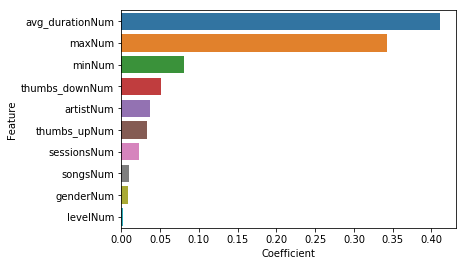

In [84]:
sns.barplot(x='Coefficient', y='Feature', data=feature_coefficient_df.iloc[:20]);

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.